In [1]:
ENV["PYTHONPATH"]="/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg/"

"/home/gridsan/aligho/.local/lib/python3.8/site-packages/PyNormaliz-2.15-py3.8-linux-x86_64.egg/"

In [1]:
println(VERSION)

1.7.2


In [2]:
using HDF5

In [2]:
analyze_symmetry_data

analyze_symmetry_data (generic function with 1 method)

In [35]:
using Crystalline, MPBUtils, SymmetryBases, PyPlot, LinearAlgebra
using MPBUtils: parse_sgnum, parse_dim


In [4]:
function findpolarizations(calcname::AbstractString, bands::UnitRange{Int64}=1:1, dir="./")
    #=readlines(dir*calcname*"-symeigs.out")
    symeigs = readdlm(dir*calcname*"-symeigs.out", ',')
    [round.(real.(parse.(ComplexF64, symeig[3:end]))) for symeig in eachrow(symeigs)]
    #readlines(dir*calcname*"-dispersion.out")
    #readdlm(dir*calcname*"-dispersion.out", ',')
    #kvs = KVec.([a[2:3] for a in eachrow(readdlm(dir*calcname*"-dispersion.out", ','))])
    =#
    println("Supplied space group is: ", parse_sgnum(calcname))
    mults = extract_multiplicities(dir*calcname, bands)
    if parse_sgnum(calcname) == 2
        Y₁ = round(Integer, mults["Y"][1])
        Γ₁ = round(Integer, mults["Γ"][1])
        A₁ = round(Integer, mults["A"][1])
        B₁ = round(Integer, mults["B"][1])
    # P₁₂ = mod(X₁ - Γ₁ - Γ₂, 2)//2
        return [mod(Y₁-Γ₁ + A₁-Γ₁, 2), mod(B₁-Γ₁ + A₁-Γ₁, 2)]
    elseif parse_sgnum(calcname) == 10
        X₁ = round(Integer, mults["X"][1])
        Γ₁ = round(Integer, mults["Γ"][1])
        Γ₂ = round(Integer, mults["Γ"][2])
        P₁₂ = mod(X₁ - Γ₁ - Γ₂, 2)
        return [P₁₂, P₁₂]    
    elseif parse_sgnum(calcname) == 16
        return 0, 0
    else 
        throw(DomainError(parse_sgnum(calcname), "Not a topological spacegroup"))
    end
end

function findcharges(calcname::AbstractString, bands::UnitRange{Int64}=1:1, dir="./")
    mults = extract_multiplicities(dir*calcname, bands)
    sgnum = parse_sgnum(calcname) == 2
    if sgnum == 2 
        Y₁ = round(Integer, mults["Y"][1])
        Γ₁ = round(Integer, mults["Γ"][1])
        A₁ = round(Integer, mults["A"][1])
        B₁ = round(Integer, mults["B"][1])
        mod((B₁-Γ₁) - (Y₁-Γ₁) + (A₁-Γ₁), 2)
    elseif sgnum == 10
        X₁ = round(Integer, mults["X"][1])
        Γ₁ = round(Integer, mults["Γ"][1])
        Γ₂ = round(Integer, mults["Γ"][2])
        mod((X₁-Γ₁-Γ₂) + 2(M₁-Γ₁) + 3(M₃-Γ₃Γ₄), 4)

    elseif sgnum == 16

    else
        throw(DomainError(sgnum, "Not a topological spacegroup"))
    end
end

function topologicalsgs()
    pgnums = (2, 6, 10)
    for pgnum in pgnums
        lgirsd = get_lgirreps(pgnum, 2)
        pgnum_kvecs = filter(isspecial, kvec.(group.(first.([lgir for (klab, lgir) in lgirsd ]))))
        println("Plane group ", pgnum)
        println("   ", pgnum_kvecs)
    end
end

function bulk_polarization_pg2(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString}) # plane group 2
    Y₁, Γ₁, A₁, B₁ = get_mult.(Ref(n), Ref(irlabs), ["Y₁", "Γ₁", "A₁", "B₁"])
    return [mod(Y₁-Γ₁ + A₁-Γ₁, 2)//2, mod(B₁-Γ₁ + A₁-Γ₁, 2)//2]
end

function bulk_polarization_pg10(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString}) # plane group 10
    X₁, Γ₁, Γ₂ = get_mult.(Ref(n), Ref(irlabs), ["X₁", "Γ₁", "Γ₂"])
    P₁₂ = mod(X₁ - Γ₁ - Γ₂, 2)//2
    return [P₁₂, P₁₂]
end

function bulk_polarization_pg16(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString})
    return [0//1, 0//1]
end

function bulk_polarization_pg16()
    return [0//1, 0//1]
end

function bulk_polarization(n::Vector{<:Integer}, sb::SymBasis)
    irlabs = sb.irlabs
    pgnum  = sb.sgnum
    pgnum == 2  && return bulk_polarization_pg2(n, irlabs)
    pgnum == 10 && return bulk_polarization_pg10(n, irlabs)
    pgnum == 16 && return bulk_polarization_pg16(n, irlabs)
    throw(DomainError(pgnum, "unsupported plane group number"))
end

function corner_charge_pg2(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString})
    Y₁, Γ₁, A₁, B₁ = get_mult.(Ref(n), Ref(irlabs), ["Y₁", "Γ₁", "A₁", "B₁"])
    return mod(-(B₁-Γ₁) - (Y₁-Γ₁) + (A₁-Γ₁), 2) // 4
end

function corner_charge_pg10(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString})
    X₁, Γ₁, Γ₂, Γ₃Γ₄, M₁, M₃ = get_mult.(Ref(n), Ref(irlabs), ["X₁", "Γ₁", "Γ₂", "Γ₃Γ₄", "M₁", "M₃M₄"])
    return mod((X₁-Γ₁-Γ₂) + 2(M₁-Γ₁) + 3(M₃-Γ₃Γ₄), 4) // 4
end

function corner_charge_pg16(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString})
    M₁, K₁, Γ₁, Γ₂, Γ₃Γ₅ = get_mult.(Ref(n), Ref(irlabs), ["M₁", "K₁", "Γ₁", "Γ₂", "Γ₃Γ₅"])
    return mod(6*(M₁-Γ₁-Γ₃Γ₅) + 4*(K₁-Γ₁-Γ₂), 24) // 24
end

function corner_charge(n::Vector{<:Integer}, sb::SymBasis)
    irlabs = sb.irlabs
    pgnum  = sb.sgnum
    pgnum == 2  && return corner_charge_pg2(n, irlabs)
    pgnum == 10 && return corner_charge_pg10(n, irlabs)
    pgnum == 16 && return corner_charge_pg16(n, irlabs)
    throw(DomainError(pgnum, "unsupported plane group number"))
end

function corner_charge(n::Vector{<:Integer}, brs::BandRepSet)
    irlabs = brs.irlabs
    pgnum  = brs.sgnum
    pgnum == 2  && return corner_charge_pg2(n, irlabs)
    pgnum == 10 && return corner_charge_pg10(n, irlabs)
    pgnum == 16 && return corner_charge_pg16(n, irlabs)
    throw(DomainError(pgnum, "unsupported plane group number"))
end

function get_mult(n::Vector{<:Integer}, irlabs::Vector{<:AbstractString}, lab::AbstractString)
    idx = findfirst(==(lab), irlabs)
    idx === nothing && throw(DomainError(lab, "non-featured irrep requested"))
    return n[idx]
end


function find_hoti(calcname::AbstractString, has_tr::Bool=true, dir="./")
    sgnum = parse_sgnum(calcname)
    D = parse_dim(calcname)
    sb, brs = compatibility_basis(sgnum, D)
    mode = contains(calcname, "te") ? "te" : "tm"
    brsmat= matrix(brs, true)
    F = smith(brsmat)
    bandirsd, lgirsd = mode == "tm" ? extract_individual_multiplicities(calcname, timereversal=has_tr, dir = dir, atol=2e-2) : extract_individual_multiplicities(calcname, timereversal=has_tr, latestarts = Dict{String, Int}(), dir = dir,atol=2e-2)
    if has_tr
        mode == "tm" && pushfirst!(bandirsd["Γ"], 1:1=>[1, zeros(length(realify(get_lgirreps(sgnum, D)["Γ"]))-1)...])
    else 
        mode == "tm" && pushfirst!(bandirsd["Γ"], 1:1=>[1, zeros(length(get_lgirreps(sgnum, D)["Γ"])-1)...])
    end
    bands, nds = collect_separable(bandirsd, lgirsd, latestarts = Dict{String, Int}())
    isempty(bands) && error("   ... found no isolatable band candidates ...")
    permd = Dict(klab => Vector{Int}(undef, length(lgirsd[klab])) for klab in sb.klabs)
    for klab in sb.klabs
        lgirs = lgirsd[klab]
        for (i, lgir) in enumerate(lgirs)
            irlab = formatirreplabel(label(lgir))
            j = findfirst(==(irlab), sb.irlabs)
            j === nothing && error("Could not find irrep label $irlab")
            permd[klab][i] = j
        end
    end
    μs = length.(bands)
    ns = [Vector{Integer}(undef, length(first(sb))) for _ in 1:length(bands)]
    for (b, (nd, μ)) in enumerate(zip(nds, μs))
        for (klab, nᵏ) in nd
            permᵏ = permd[klab]
            ns[b][permᵏ] .= nᵏ
        end
        ns[b][end] = μ
    end
    println(ns)
    polarizations = bulk_polarization.(ns, Ref(sb))
    corner_charges = corner_charge.(ns, Ref(sb))
    return bands, [float.(pol) for pol in polarizations], [float.(charge) for charge in corner_charges]
end

function find_hoti_bands(calcname::AbstractString)
    b, p, q = find_hoti(calcname)
    relevant_bands1 = (iszero).(p)
    relevant_bands2 = (!iszero).(q)
    relevant_bands = relevant_bands1 .& relevant_bands2
    return b[relevant_bands], p[relevant_bands], q[relevant_bands]
end

function extract_gaps(calcname::AbstractString, whichgap::Tuple{<:Integer, <:Integer}=(1, 2))
    #By default we look at the fundamental gap, though this can be modified by changing whichgap
    band1, band2 = whichgap
    bandsathighk = [parse.(Float64, split(line, ","))[6:end] for line in readlines(calcname)]
    #println(bandsathighk)
    min_band2 = minimum([bands[band2] for bands in bandsathighk])
    #println(min_band2)
    max_band1 = maximum([bands[band1] for bands in bandsathighk])

    return min_band2-max_band1
end


function label_topology_and_hoti(calcname::AbstractString)

    topologies_and_sets = label_topologies(calcname, true, "./", printisbandstruct=false, verbose=true)
    hoti_charges = find_hoti(calcname)[3]
    for (i, (s, t)) in enumerate(topologies_and_sets[1:end-1])
        #println(extract_gaps(calcname*"-dispersion.out", (s[end],topologies_and_sets[i+1][1][1]) ))
    end

    return [[tands..., c ] for (tands, c) in zip(topologies_and_sets, hoti_charges)]
end

label_topology_and_hoti (generic function with 1 method)

In [4]:
symeigsd, lgd = read_symdata("dim2-sg17-240-res64-te", dir="./symeigs/output")
    lgirsd = pick_lgirreps(lgd)

    # determine how we can consistently group up irreps and bands across distinct k-points
    bandirsd = MPBUtils.find_individual_multiplicities(symeigsd, lgirsd, atol=1e-2)


Dict{String, Vector{Pair{UnitRange{Int64}, Vector{Int64}}}} with 3 entries:
  "M" => [1:1=>[0, 1, 0, 0], 2:2=>[0, 0, 1, 0], 3:3=>[0, 1, 0, 0], 4:4=>[0, 0, …
  "Γ" => [2:2=>[0, 1, 0, 0, 0, 0], 3:3=>[0, 0, 1, 0, 0, 0], 4:5=>[0, 0, 0, 0, 0…
  "K" => [1:1=>[0, 1, 0], 2:3=>[0, 0, 1], 4:4=>[0, 1, 0], 5:6=>[0, 0, 1], 7:7=>…

In [61]:
fieldnames(typeof(first(first(lgirsd)[2])))

(:cdml, :g, :matrices, :translations, :reality, :iscorep)

In [115]:
function label_topologies(symeigsd::Dict{String, Vector{Vector{ComplexF64}}}, lgirsd::Dict{String, Vector{LGIrrep{D}}}, sgnum::Integer, has_tr::Bool=true; verbose::Bool=false, printisbandstruct::Bool=false, atol::Real=1e-2) where D
    brs = bandreps(sgnum, D)
    bandirsd = MPBUtils.find_individual_multiplicities(symeigsd, lgirsd; atol, latestarts = Dict{String, Int}())
    bands, ns = extract_candidate_symmetryvectors(bandirsd, lgirsd, brs; latestarts = Dict{String, Int}() )
    verbose && println("bands: ", bands, "\nns:", ns)
    band_topologies = Vector{Pair{UnitRange{Int}, TopologyKind}}()
    minband = 1
    for (indx, band) in enumerate(bands)
        minimum(band) == minband || continue
        new_bands, new_ns = find_mintoposet(bands, ns, indx, brs)
        verbose && println(new_bands, "   ", new_ns)
        printisbandstruct && println(isbandstruct(new_ns, brs))
        !isnothing(new_ns) && push!(band_topologies, new_bands => calc_detailed_topology(new_ns, brs))
        minband = maximum(new_bands) + 1
    end
    return band_topologies
end

function find_mintoposet(bands::Vector{<:UnitRange{<:Integer}}, ns::Vector{<:Vector{<:Integer}}, idx::Integer, brs::BandRepSet)
    nprime = ns[idx]
    bandsprime = minimum(bands[idx]):maximum(bands[idx])
    for (band, n) in zip(bands[idx+1:end], ns[idx+1:end])
        isbandstruct(nprime, brs) && break
        nprime = nprime + n
        bandsprime = minimum(bands[idx]):maximum(band)
    end
    isbandstruct(nprime, brs) ? (bandsprime, nprime) : (bandsprime, nothing)
end


find_mintoposet (generic function with 2 methods)

In [116]:
label_topologies(symeigsd, lgirsd, 17, atol=1e-3, verbose=true)

bands: UnitRange{Int64}[1:1, 2:3, 4:7, 8:9, 10:11, 12:13, 14:19, 20:20, 21:22, 23:25, 26:28, 29:31, 32:37]
ns:[[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1], [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2], [0, 1, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 1, 4], [0, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 2], [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2], [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2], [2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 6], [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 2], [1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 3], [0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 3], [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 3], [2, 1, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 2, 6]]
1:1   [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1]
2:3   [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2]
4:9   [0, 2, 2, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2, 6]
10:13   [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 4]
14:19   [2, 2, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 6]
20:22   [0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 2, 0, 3]
23:37   [4, 3, 4,

7-element Vector{Pair{UnitRange{Int64}, TopologyKind}}:
   1:1 => TRIVIAL
   2:3 => TRIVIAL
   4:9 => TRIVIAL
 10:13 => TRIVIAL
 14:19 => TRIVIAL
 20:22 => FRAGILE
 23:37 => TRIVIAL

In [67]:
methods(isbandstruct)

# 3 methods for generic function "isbandstruct":
[1] isbandstruct(n::AbstractVector{<:Integer}, F::Smith; allow_nonphysical) in SymmetryBases at /home/gridsan/aligho/.julia/packages/SymmetryBases/EvH2o/src/symvec.jl:248
[2] isbandstruct(n::AbstractVector{<:Integer}, B::Matrix{<:Integer}; kws...) in SymmetryBases at /home/gridsan/aligho/.julia/packages/SymmetryBases/EvH2o/src/symvec.jl:262
[3] isbandstruct(n::AbstractVector{<:Integer}, BRS::BandRepSet; kws...) in SymmetryBases at /home/gridsan/aligho/.julia/packages/SymmetryBases/EvH2o/src/symvec.jl:263

In [5]:
function label_topologies(calcname::AbstractString, has_tr::Bool=true, dir="./"; verbose::Bool=false, printisbandstruct::Bool=false, atol=1e-2)
    sgnum = parse_sgnum(calcname)
    D = parse_dim(calcname)
    brs = bandreps(sgnum, D)
    mode = contains(calcname, "te") ? "te" : "tm"
    brsmat= matrix(brs, true)
    F = smith(brsmat)
    bandirsd, lgirsd = mode == "tm" ? extract_individual_multiplicities(calcname, timereversal=has_tr, dir = dir, atol=atol) : extract_individual_multiplicities(calcname, timereversal=has_tr, latestarts = Dict{String, Int}(), dir = dir,atol=atol)
    if has_tr
        mode == "tm" && pushfirst!(bandirsd["Γ"], 1:1=>[1, zeros(length(realify(get_lgirreps(sgnum, D)["Γ"]))-1)...])
    else 
        mode == "tm" && pushfirst!(bandirsd["Γ"], 1:1=>[1, zeros(length(get_lgirreps(sgnum, D)["Γ"])-1)...])
    end
    bands, nds = collect_separable(bandirsd, lgirsd, latestarts = Dict{String, Int}())
    isempty(bands) && error("   ... found no isolatable band candidates ...")
    bands, ns = extract_candidate_symmetryvectors(bandirsd, lgirsd, brs; latestarts = Dict{String, Int}() )
    minband = 1
    verbose && println("bands: ", bands)
    verbose && println("ns: ", ns)
    returnbands = []
    for (indx, band) in enumerate(bands)
        #println(indx)
        minimum(band) == minband || continue
        a, b = find_mintoposet(bands, ns, indx, F )
        verbose && println(a, "   ", b)
        printisbandstruct && println(isbandstruct(b, F))
        !isnothing(b) && push!(returnbands, [a, calc_detailed_topology(b, brs)])
        minband = maximum(a) + 1
    end
    return returnbands
end

function label_corner(calcname::AbstractString, has_tr::Bool=true, dir="./"; verbose::Bool=false, printisbandstruct::Bool=false, atol=1e-2)
    sgnum = parse_sgnum(calcname)
    D = parse_dim(calcname)
    brs = bandreps(sgnum, D)
    irlabs = brs.irlabs
    mode = contains(calcname, "te") ? "te" : "tm"
    brsmat= matrix(brs, true)
    F = smith(brsmat)
    bandirsd, lgirsd = mode == "tm" ? extract_individual_multiplicities(calcname, timereversal=has_tr, dir = dir, atol=atol) : extract_individual_multiplicities(calcname, timereversal=has_tr, latestarts = Dict{String, Int}(), dir = dir,atol=atol)
    if has_tr
        mode == "tm" && pushfirst!(bandirsd["Γ"], 1:1=>[1, zeros(length(realify(get_lgirreps(sgnum, D)["Γ"]))-1)...])
    else 
        mode == "tm" && pushfirst!(bandirsd["Γ"], 1:1=>[1, zeros(length(get_lgirreps(sgnum, D)["Γ"])-1)...])
    end
    bands, nds = collect_separable(bandirsd, lgirsd, latestarts = Dict{String, Int}())
    isempty(bands) && error("   ... found no isolatable band candidates ...")
    bands, ns = extract_candidate_symmetryvectors(bandirsd, lgirsd, brs; latestarts = Dict{String, Int}() )
    minband = 1
    verbose && println("bands: ", bands)
    verbose && println("ns: ", ns)
    returnbands = []
    for (indx, band) in enumerate(bands)
        #println(indx)
        minimum(band) == minband || continue
        a, b = find_mintoposet(bands, ns, indx, F )
        verbose && println(a, "   ", b)
        printisbandstruct && println(isbandstruct(b, F))
        !isnothing(b) && push!(returnbands, [a, corner_charge(b, brs)])
        minband = maximum(a) + 1
    end
    return returnbands
end



function find_mintoposet(bands::Vector{<:UnitRange{<:Integer}}, ns::Vector{<:Vector{<:Integer}}, idx::Integer, F::Smith{Int64,Array{Int64,2}})
    nprime = ns[idx]
    bandsprime = minimum(bands[idx]):maximum(bands[idx])
    for (band, n) in zip(bands[idx+1:end], ns[idx+1:end])
        isbandstruct(nprime, F) && break
        nprime = nprime + n
        bandsprime = minimum(bands[idx]):maximum(band)
    end
    isbandstruct(nprime, F) ? (bandsprime, nprime) : (bandsprime, nothing)
end


find_mintoposet (generic function with 1 method)

In [6]:
bandirsd, lgirsd = extract_individual_multiplicities("dim2-sg16-2-res64-te", timereversal=true, dir = "./symeigs/output", atol=2e-2, latestarts = Dict{String, Int}());

In [7]:
run(`cat ./symeigs/output/dim2-sg12-102-res64-tm-symeigs.out`)

1,"+x,+y",0.9999999999999999+0.0i,0.9999999999999993+0.0i,0.9999999999999983+0.0i,1.000000000000001+0.0i,0.9999999999999993+0.0i,1.0000000000000016+0.0i,1.000000000000004+0.0i,1.000000000000002+0.0i,1.0000000000000027+0.0i,1.0000000000000016+0.0i,1.000000000000003+0.0i,0.9999999999999992+0.0i,0.9999999999999974+0.0i,1.000000000000001+0.0i,1.0000000000000027+0.0i,1.0+0.0i,1.0000000000000002+0.0i,1.0000000000000036+0.0i,1.0000000000000002+0.0i,0.999999999999999+0.0i,0.9999999999999989+0.0i,0.9999999999999988+0.0i,1.0000000000000016+0.0i,0.9999999999999954+0.0i,1.0000000000000009+0.0i,0.9999999999999996+0.0i,1.0000000000000002+0.0i,0.999999999999996+0.0i,1.0000000000000009+0.0i,0.9999999999999978+0.0i,1.0000000000000007+0.0i,1.0000000000000002+0.0i,1.0000000000000018+0.0i,1.0000000000000002+0.0i,0.9999999999999966+0.0i,1.0000000000000024+0.0i,0.9999999999999977+0.0i,0.9999999999999993+0.0i,1.0000000000000002+0.0i,0.9999999999999977+0.0i
1,"-x,-y",-0.9999995293261047+3.482284795060437e-18i

Process(`cat ./symeigs/output/dim2-sg12-102-res64-tm-symeigs.out`, ProcessExited(0))

In [82]:
spacegroup(13, 2)

SpaceGroup{2} ⋕13 (p3) with 3 operations:
 1
 3⁺
 3⁻

In [5]:
label_topologies("dim2-sg12-102-res64-tm", true, "./symeigs/output", verbose=false, atol=2e-2)

4-element Vector{Any}:
 Any[1:4, TRIVIAL]
 Any[5:10, TRIVIAL]
 Any[11:12, TRIVIAL]
 Any[13:34, TRIVIAL]

In [78]:
compatibility_basis(12, 2)[1]

SymBasis (#12): 10 Hilbert vectors, sampling 9 LGIrreps (spin-1 w/ TR)
──────┬───────────────────────────────
      │ 1  2  3  4  5  6  7  8  9  10 
──────┼───────────────────────────────
 M₁M₃ │ ·  ·  ·  ·  1  1  1  1  1  1  
 M₂M₄ │ ·  ·  ·  1  ·  1  1  1  1  1  
 M₅   │ 1  1  1  ·  ·  ·  ·  ·  ·  ·  
 X₁   │ 1  1  1  1  1  2  2  2  2  2
 Γ₁   │ ·  ·  1  ·  1  ·  ·  ·  1  2  
 Γ₂   │ ·  1  ·  1  ·  ·  1  2  ·  ·  
 Γ₃   │ ·  1  ·  ·  1  ·  1  2  ·  ·  
 Γ₄   │ ·  ·  1  1  ·  ·  ·  ·  1  2  
 Γ₅   │ 1  ·  ·  ·  ·  2  1  ·  1  ·  
──────┼───────────────────────────────
 μ    │ 2  2  2  2  2  4  4  4  4  4  
──────┴───────────────────────────────
  KVecs: M, X, Γ

In [44]:
function topology_bandgroupings_and_corner(id::Integer, polarization::AbstractString, sg::Integer = 2)
    
    g = label_topologies("dim2-sg$sg-$id-res64-$polarization", true, "./symeigs/output")
    
    topo = Int.(isequal.(TopologyKind(1), [grouping[2] for grouping in g]))
    fragile = Int.(isequal.(TopologyKind(2), [grouping[2] for grouping in g]))
    c = []

    if (sg == 16 || sg == 10 || sg == 2)
        c = vcat(c, [v[2] for v in label_corner("dim2-sg$sg-$id-res64-$polarization", true, "./symeigs/output")])
    else 
        c = zeros(40)
    end
    vcat(topo, zeros(40 - length(topo))),  vcat(fragile, zeros(40 - length(topo))), (!iszero).(vcat(c, zeros(40 - length(c)))), 
    vcat(length.([first(grouping) for grouping in g]), zeros(40 - length(g)))
end

topology_bandgroupings_and_corner (generic function with 2 methods)

In [9]:
id = 100
polarization="te"
sg=16
t, f, c, num_bands= topology_bandgroupings_and_corner(id, polarization, sg)


([0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Bool[0, 1, 0, 1, 1, 1, 1, 0, 0, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1.0, 2.0, 5.0, 3.0, 4.0, 3.0, 3.0, 1.0, 3.0, 3.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [10]:
all_topological_te = []
all_fragile_te = []
all_charges_te = []
all_topological_tm = []
all_fragile_tm = []
all_charges_tm = []

all_num_bands_te = []
all_num_bands_tm = []

n_groupings = 40
for sg in (2, 9, 10, 11, 12, 13, 14, 15, 16, 17)
    topological_te = zeros(n_groupings)
    fragile_te = zeros(n_groupings)
    charges_te = zeros(n_groupings)
    topological_tm = zeros(n_groupings)
    fragile_tm = zeros(n_groupings)
    charges_tm = zeros(n_groupings)
    num_bands_te = zeros(n_groupings, n_groupings)
    num_bands_tm = zeros(n_groupings, n_groupings)

    sg in (2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17) || continue
    println("Calculating spacegroup $sg"); flush(stdout)
    for id in 1:5
        for polarization in ("te", "tm")
            try
                t, f, c, num_bands= topology_bandgroupings_and_corner(id, polarization, sg)
                num_bands = Int.(num_bands)
                if polarization == "te"
                    fragile_te += f
                    topological_te += t
                    charges_te += c
                    for (i, nband) in enumerate(num_bands)
                        iszero(nband) && continue
                        num_bands_te[i, nband] += 1
                    end
                else
                    fragile_tm += f
                    topological_tm += t
                    charges_tm += c
                    for (i, nband) in enumerate(num_bands)
                        iszero(nband) && continue
                        num_bands_tm[i, nband] += 1
                    end
                end
            catch
            end
        end
    end
    push!(all_num_bands_te, num_bands_te)
    push!(all_num_bands_tm, num_bands_tm)
    push!(all_fragile_te, fragile_te)
    push!(all_topological_te, topological_te)
    push!(all_charges_te, charges_te)
    push!(all_fragile_tm, fragile_tm)
    push!(all_topological_tm, topological_tm)
    push!(all_charges_tm, charges_tm)

    #=for polarization in ("te", "tm")
        println("sg $sg of polarization $polarization $(has_fragile[polarization]) lattices")
        println("sg $sg of polarization $polarization $(has_topological[polarization]) lattices")
        flush(stdout)
end=#
end

Calculating spacegroup 2
Calculating spacegroup 9
Calculating spacegroup 10
Calculating spacegroup 11
Calculating spacegroup 12
Calculating spacegroup 13
Calculating spacegroup 14
Calculating spacegroup 15
Calculating spacegroup 16
Calculating spacegroup 17


In [11]:
all_fragile_te

10-element Vector{Any}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

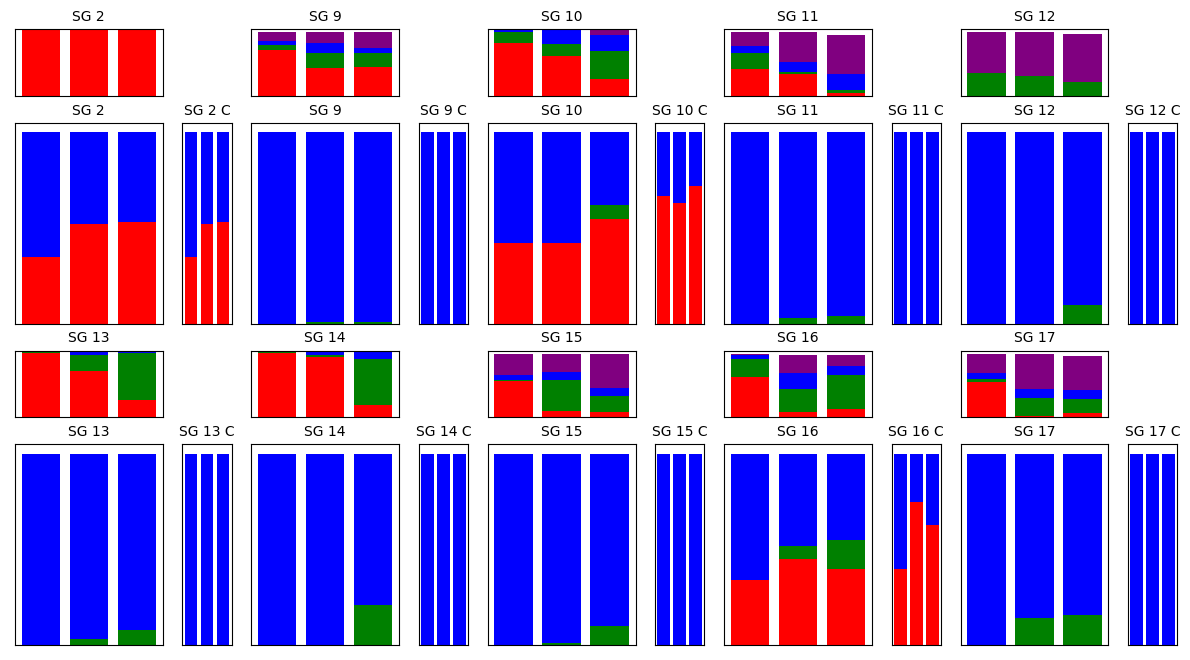

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [58]:
sgs = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]

num_ids = 100
band_set_range = 1:3
fig, (axes) = subplots(4, 10, figsize=(15, 8), gridspec_kw=Dict("width_ratios" => [3, 1, 3, 1, 3, 1, 3, 1, 3, 1], "height_ratios" => [1, 3, 1, 3]))
#xlabel("Band Grouping")
ax_num = 1
for (i, sg) in enumerate(sgs)
    row = i > 5 ? 2 : 1
    col = rem(i, 5)
    col = iszero(col) ? 5 : col
    #println("row: $row, col: $col")
    #xticks(1:20)
    axes[2row, 2col-1].set_title("SG $sg", size=10)
    axes[2row, 2col-1].bar(band_set_range, all_topological_te[i][band_set_range], color="red", label="topological")
    axes[2row, 2col-1].bar(band_set_range, all_fragile_te[i][band_set_range], bottom = all_topological_te[i][band_set_range], color="green", label = "fragile")
    axes[2row, 2col-1].bar(band_set_range, num_ids .- all_topological_te[i][band_set_range] .- all_fragile_te[i][band_set_range], bottom = all_topological_te[i][band_set_range] + all_fragile_te[i][band_set_range], color="blue", label="trivial")
    axes[2row, 2col].set_title("SG $sg C", size=10)
    axes[2row, 2col].bar(band_set_range, all_charges_te[i][band_set_range], color="red", label="w/ corner charge")
    axes[2row, 2col].bar(band_set_range, num_ids .- all_charges_te[i][band_set_range], bottom = all_charges_te[i][band_set_range], color="blue", label="w/o corner charge")
    
    
    axes[2row, 2col-1].set_yticks([])
    axes[2row, 2col].set_yticks([])
    axes[2row, 2col-1].set_xticks([])
    axes[2row, 2col].set_xticks([])
    axes[2row-1, 2col-1].set_yticks([])
    axes[2row-1, 2col].set_yticks([])
    axes[2row-1, 2col-1].set_xticks([])
    axes[2row-1, 2col].set_xticks([])
    
    axes[2row-1, 2col-1].set_title("SG $sg", size=10)
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 1], color="red", label="topological")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 2], bottom =  all_num_bands_te[i][band_set_range, 1], color="green", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 3], bottom =  vec(sum(all_num_bands_te[i][band_set_range, 1:2], dims=2)), color="blue", label = "fragile")

    axes[2row-1, 2col-1].bar(band_set_range, vec(sum(all_num_bands_te[i][band_set_range, 4:end], dims=2)), bottom =  vec(sum(all_num_bands_te[i][band_set_range, 1:3], dims=2)), color="purple", label = "fragile")
end
delaxes.(axes[1, 2:2:10])
delaxes.(axes[3, 2:2:10])

#legend()


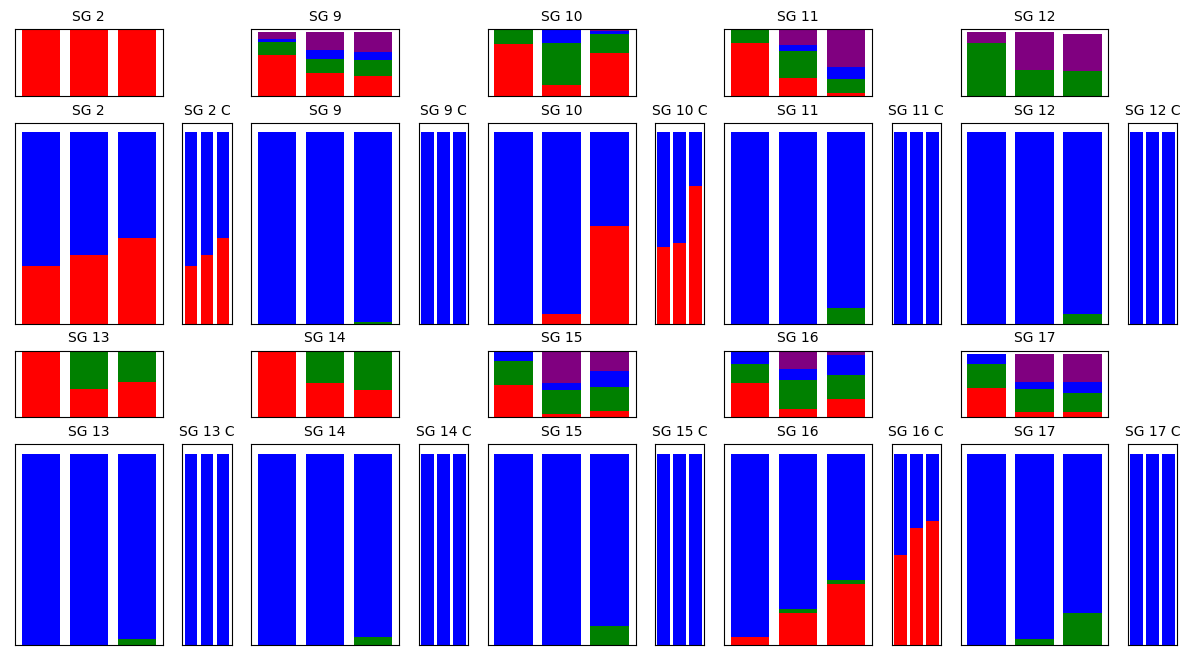

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [60]:
sgs = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]

num_ids = 100
band_set_range = 1:3
fig, (axes) = subplots(4, 10, figsize=(15, 8), gridspec_kw=Dict("width_ratios" => [3, 1, 3, 1, 3, 1, 3, 1, 3, 1], "height_ratios" => [1, 3, 1, 3]))
#xlabel("Band Grouping")
ax_num = 1
for (i, sg) in enumerate(sgs)
    row = i > 5 ? 2 : 1
    col = rem(i, 5)
    col = iszero(col) ? 5 : col
    #println("row: $row, col: $col")
    #xticks(1:20)
    axes[2row, 2col-1].set_title("SG $sg", size=10)
    axes[2row, 2col-1].bar(band_set_range, all_topological_tm[i][band_set_range], color="red", label="topological")
    axes[2row, 2col-1].bar(band_set_range, all_fragile_tm[i][band_set_range], bottom = all_topological_tm[i][band_set_range], color="green", label = "fragile")
    axes[2row, 2col-1].bar(band_set_range, num_ids .- all_topological_tm[i][band_set_range] .- all_fragile_tm[i][band_set_range], bottom = all_topological_tm[i][band_set_range] + all_fragile_tm[i][band_set_range], color="blue", label="trivial")
    axes[2row, 2col].set_title("SG $sg C", size=10)
    axes[2row, 2col].bar(band_set_range, all_charges_tm[i][band_set_range], color="red", label="w/ corner charge")
    axes[2row, 2col].bar(band_set_range, num_ids .- all_charges_tm[i][band_set_range], bottom = all_charges_tm[i][band_set_range], color="blue", label="w/o corner charge")
    
    
    axes[2row, 2col-1].set_yticks([])
    axes[2row, 2col].set_yticks([])
    axes[2row, 2col-1].set_xticks([])
    axes[2row, 2col].set_xticks([])
    axes[2row-1, 2col-1].set_yticks([])
    axes[2row-1, 2col].set_yticks([])
    axes[2row-1, 2col-1].set_xticks([])
    axes[2row-1, 2col].set_xticks([])
    
    axes[2row-1, 2col-1].set_title("SG $sg", size=10)
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_tm[i][band_set_range, 1], color="red", label="topological")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_tm[i][band_set_range, 2], bottom =  all_num_bands_tm[i][band_set_range, 1], color="green", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_tm[i][band_set_range, 3], bottom =  vec(sum(all_num_bands_tm[i][band_set_range, 1:2], dims=2)), color="blue", label = "fragile")

    axes[2row-1, 2col-1].bar(band_set_range, vec(sum(all_num_bands_tm[i][band_set_range, 4:end], dims=2)), bottom =  vec(sum(all_num_bands_tm[i][band_set_range, 1:3], dims=2)), color="purple", label = "fragile")
end
delaxes.(axes[1, 2:2:10])
delaxes.(axes[3, 2:2:10])


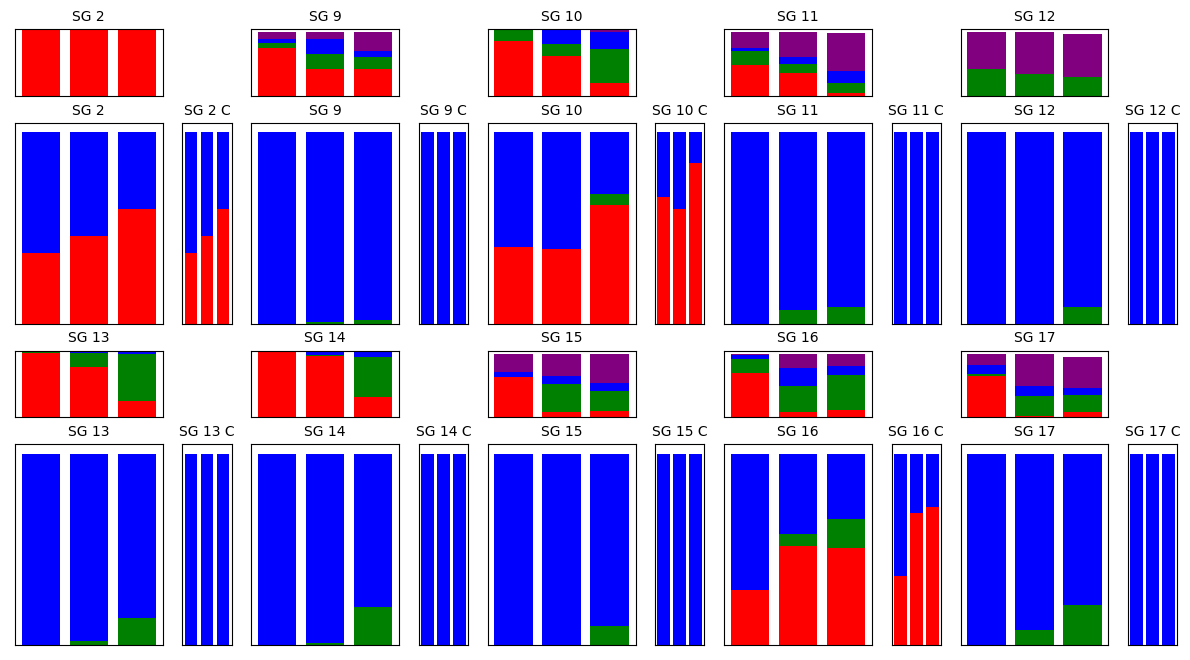

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [62]:
sgs = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]

num_ids = 100
band_set_range = 1:3
fig, (axes) = subplots(4, 10, figsize=(15, 8), gridspec_kw=Dict("width_ratios" => [3, 1, 3, 1, 3, 1, 3, 1, 3, 1], "height_ratios" => [1, 3, 1, 3]))
#xlabel("Band Grouping")
ax_num = 1
for (i, sg) in enumerate(sgs)
    row = i > 5 ? 2 : 1
    col = rem(i, 5)
    col = iszero(col) ? 5 : col
    #println("row: $row, col: $col")
    #xticks(1:20)
    axes[2row, 2col-1].set_title("SG $sg", size=10)
    axes[2row, 2col-1].bar(band_set_range, all_topological_te[i][band_set_range], color="red", label="topological")
    axes[2row, 2col-1].bar(band_set_range, all_fragile_te[i][band_set_range], bottom = all_topological_te[i][band_set_range], color="green", label = "fragile")
    axes[2row, 2col-1].bar(band_set_range, num_ids .- all_topological_te[i][band_set_range] .- all_fragile_te[i][band_set_range], bottom = all_topological_te[i][band_set_range] + all_fragile_te[i][band_set_range], color="blue", label="trivial")
    axes[2row, 2col].set_title("SG $sg C", size=10)
    axes[2row, 2col].bar(band_set_range, all_charges_te[i][band_set_range], color="red", label="w/ corner charge")
    axes[2row, 2col].bar(band_set_range, num_ids .- all_charges_te[i][band_set_range], bottom = all_charges_te[i][band_set_range], color="blue", label="w/o corner charge")
    
    
    axes[2row, 2col-1].set_yticks([])
    axes[2row, 2col].set_yticks([])
    axes[2row, 2col-1].set_xticks([])
    axes[2row, 2col].set_xticks([])
    axes[2row-1, 2col-1].set_yticks([])
    axes[2row-1, 2col].set_yticks([])
    axes[2row-1, 2col-1].set_xticks([])
    axes[2row-1, 2col].set_xticks([])
    
    axes[2row-1, 2col-1].set_title("SG $sg", size=10)
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 1], color="red", label="topological")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 2], bottom =  all_num_bands_te[i][band_set_range, 1], color="green", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 3], bottom =  vec(sum(all_num_bands_te[i][band_set_range, 1:2], dims=2)), color="blue", label = "fragile")

    axes[2row-1, 2col-1].bar(band_set_range, vec(sum(all_num_bands_te[i][band_set_range, 4:end], dims=2)), bottom =  vec(sum(all_num_bands_te[i][band_set_range, 1:3], dims=2)), color="purple", label = "fragile")
end
delaxes.(axes[1, 2:2:10])
delaxes.(axes[3, 2:2:10])


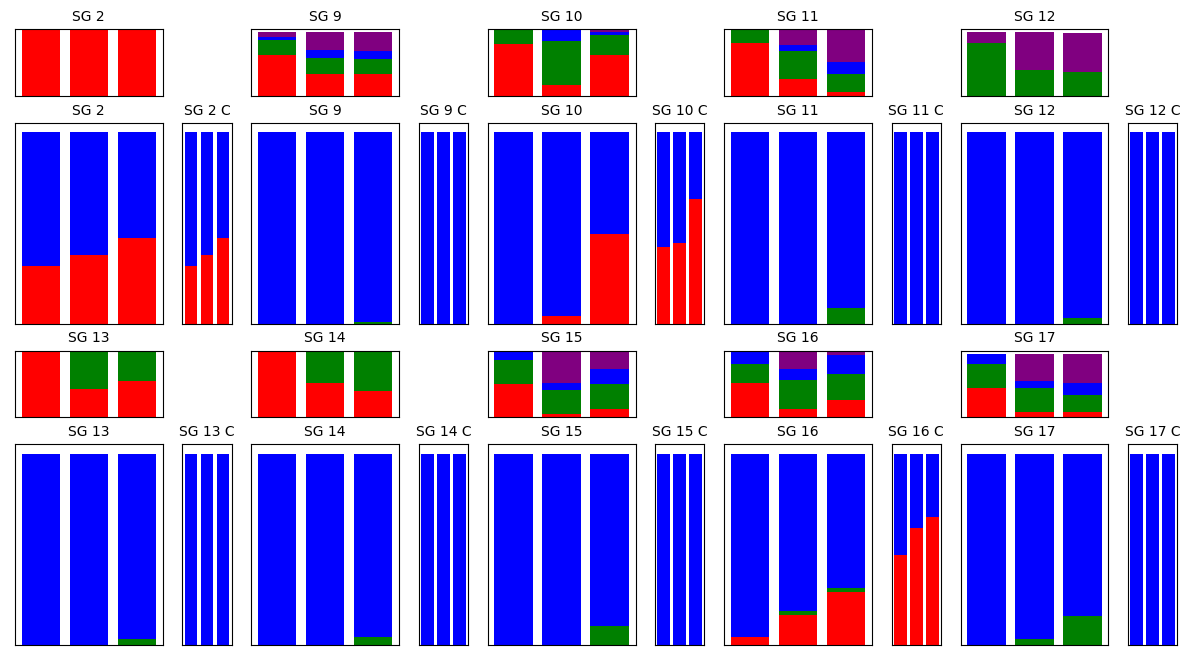

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [63]:
sgs = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]

num_ids = 100
band_set_range = 1:3
fig, (axes) = subplots(4, 10, figsize=(15, 8), gridspec_kw=Dict("width_ratios" => [3, 1, 3, 1, 3, 1, 3, 1, 3, 1], "height_ratios" => [1, 3, 1, 3]))
#xlabel("Band Grouping")
ax_num = 1
for (i, sg) in enumerate(sgs)
    row = i > 5 ? 2 : 1
    col = rem(i, 5)
    col = iszero(col) ? 5 : col
    #println("row: $row, col: $col")
    #xticks(1:20)
    axes[2row, 2col-1].set_title("SG $sg", size=10)
    axes[2row, 2col-1].bar(band_set_range, all_topological_tm[i][band_set_range], color="red", label="topological")
    axes[2row, 2col-1].bar(band_set_range, all_fragile_tm[i][band_set_range], bottom = all_topological_tm[i][band_set_range], color="green", label = "fragile")
    axes[2row, 2col-1].bar(band_set_range, num_ids .- all_topological_tm[i][band_set_range] .- all_fragile_tm[i][band_set_range], bottom = all_topological_tm[i][band_set_range] + all_fragile_tm[i][band_set_range], color="blue", label="trivial")
    axes[2row, 2col].set_title("SG $sg C", size=10)
    axes[2row, 2col].bar(band_set_range, all_charges_tm[i][band_set_range], color="red", label="w/ corner charge")
    axes[2row, 2col].bar(band_set_range, num_ids .- all_charges_tm[i][band_set_range], bottom = all_charges_tm[i][band_set_range], color="blue", label="w/o corner charge")
    
    
    axes[2row, 2col-1].set_yticks([])
    axes[2row, 2col].set_yticks([])
    axes[2row, 2col-1].set_xticks([])
    axes[2row, 2col].set_xticks([])
    axes[2row-1, 2col-1].set_yticks([])
    axes[2row-1, 2col].set_yticks([])
    axes[2row-1, 2col-1].set_xticks([])
    axes[2row-1, 2col].set_xticks([])
    
    axes[2row-1, 2col-1].set_title("SG $sg", size=10)
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_tm[i][band_set_range, 1], color="red", label="topological")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_tm[i][band_set_range, 2], bottom =  all_num_bands_tm[i][band_set_range, 1], color="green", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_tm[i][band_set_range, 3], bottom =  vec(sum(all_num_bands_tm[i][band_set_range, 1:2], dims=2)), color="blue", label = "fragile")

    axes[2row-1, 2col-1].bar(band_set_range, vec(sum(all_num_bands_tm[i][band_set_range, 4:end], dims=2)), bottom =  vec(sum(all_num_bands_tm[i][band_set_range, 1:3], dims=2)), color="purple", label = "fragile")
end
delaxes.(axes[1, 2:2:10])
delaxes.(axes[3, 2:2:10])


In [83]:
# Add corner charge for spacegroup 13 

In [12]:
readdir("./symeigs/output")

198000-element Vector{String}:
 "dim2-sg10-1-res64-te-dispersion.out"
 "dim2-sg10-1-res64-te-epsilon.h5"
 "dim2-sg10-1-res64-te-symeigs.out"
 "dim2-sg10-1-res64-tm-dispersion.out"
 "dim2-sg10-1-res64-tm-epsilon.h5"
 "dim2-sg10-1-res64-tm-symeigs.out"
 "dim2-sg10-10-res64-te-dispersion.out"
 "dim2-sg10-10-res64-te-epsilon.h5"
 "dim2-sg10-10-res64-te-symeigs.out"
 "dim2-sg10-10-res64-tm-dispersion.out"
 "dim2-sg10-10-res64-tm-epsilon.h5"
 "dim2-sg10-10-res64-tm-symeigs.out"
 "dim2-sg10-100-res64-te-dispersion.out"
 ⋮
 "dim2-sg9-998-res64-te-dispersion.out"
 "dim2-sg9-998-res64-te-epsilon.h5"
 "dim2-sg9-998-res64-te-symeigs.out"
 "dim2-sg9-998-res64-tm-dispersion.out"
 "dim2-sg9-998-res64-tm-epsilon.h5"
 "dim2-sg9-998-res64-tm-symeigs.out"
 "dim2-sg9-999-res64-te-dispersion.out"
 "dim2-sg9-999-res64-te-epsilon.h5"
 "dim2-sg9-999-res64-te-symeigs.out"
 "dim2-sg9-999-res64-tm-dispersion.out"
 "dim2-sg9-999-res64-tm-epsilon.h5"
 "dim2-sg9-999-res64-tm-symeigs.out"

In [50]:
using PyCall
using HDF5
h5py = pyimport("h5py")

PyObject <module 'h5py' from '/home/gridsan/aligho/.local/lib/python3.8/site-packages/h5py/__init__.py'>

In [33]:
dir="./symeigs/output/"
filename = "$(dir)dim2-sg10-10-res64-tm-epsilon.h5"
fid = h5open(filename, "r")

🗂️ HDF5.File: (read-only) ./symeigs/output/dim2-sg10-10-res64-tm-epsilon.h5
├─ 🔢 data
├─ 🔢 description
├─ 🔢 epsilon.xx
├─ 🔢 epsilon.xy
├─ 🔢 epsilon.xy.i
├─ 🔢 epsilon.xz
├─ 🔢 epsilon.xz.i
├─ 🔢 epsilon.yy
├─ 🔢 epsilon.yz
├─ 🔢 epsilon.yz.i
├─ 🔢 epsilon.zz
├─ 🔢 epsilon_inverse.xx
├─ 🔢 epsilon_inverse.xy
├─ 🔢 epsilon_inverse.xy.i
├─ 🔢 epsilon_inverse.xz
├─ 🔢 epsilon_inverse.xz.i
├─ 🔢 epsilon_inverse.yy
├─ 🔢 epsilon_inverse.yz
├─ 🔢 epsilon_inverse.yz.i
├─ 🔢 epsilon_inverse.zz
└─ 🔢 lattice vectors

In [49]:
#read(fid["data"])
close(fid)

In [67]:
ave_epsilon_topo = zeros(10, 64, 64)
ave_epsilon_fragile = zeros(10, 64, 64)

dir="./symeigs/output/"

n_groupings = 40
for (sg_id, sg) in enumerate((2, 9, 10, 11, 12, 13, 14, 15, 16, 17))
    sg in (2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17) || continue
    brs = bandreps(sg, 2)
    println("Calculating spacegroup $sg"); flush(stdout)
    
    proto_n_topo = Float64[]
    proto_n_fragile = Float64[]

    for id in 1:100
        polarization = "te"
        try
            symeigsd, lgd = read_symdata("dim2-sg$sg-$id-res64-$polarization", dir="./symeigs/output")
            lgirsd = pick_lgirreps(lgd)
            lg_gamma = lgd["Γ"]
            signs = [det(rotation(g)) for g in lg_gamma]
            if polarization == "tm"
                symeigsd["Γ"][1] = ones(length(signs))
            end
            bsummary = first(analyze_symmetry_data(symeigsd, lgirsd, brs))
            f = isequal(bsummary.topology, TopologyKind(2)) 
            t = isequal(bsummary.topology, TopologyKind(1))
            if t 
                filename = "$(dir)dim2-sg$(sg)-$id-res64-$(polarization)-epsilon.h5"
                fid = h5open(filename, "r")
                if isempty(proto_n_topo)
                    ave_epsilon_topo[sg_id, :, :] +=  read(fid["data"])
                    proto_n_topo = bsummary.n
                    println(proto_n_topo)
                else
                    (bsummary.n == proto_n_topo) || continue
                    ave_epsilon_topo[sg_id, :, :] +=  read(fid["data"])
                end
                
                close(fid)

            end
            if  f
                filename = "$(dir)dim2-sg$(sg)-$id-res64-$(polarization)-epsilon.h5"
                fid = h5open(filename, "r")
                if isempty(proto_n_fragile)
                    ave_epsilon_fragile[sg_id, :, :] +=  read(fid["data"])
                    proto_n_fragile = bsummary.n
                else
                    (bsummary.n == proto_n_fragile) || continue
                    ave_epsilon_fragile[sg_id, :, :] +=  read(fid["data"])
                end
                
                close(fid)
            end
        catch e
            println(e)
        end
    end
end

Calculating spacegroup 2
[1, 0, 0, 1, 1, 0, 1, 0, 1]
Calculating spacegroup 9
Calculating spacegroup 10
[1, 0, 0, 1, 0, 1, 0, 0, 1]
Calculating spacegroup 11
Calculating spacegroup 12
Calculating spacegroup 13
Calculating spacegroup 14
Calculating spacegroup 15
Calculating spacegroup 16
[1, 1, 2, 0, 0, 0, 0, 1, 2]
Calculating spacegroup 17
ErrorException("found no isolable band candidates")


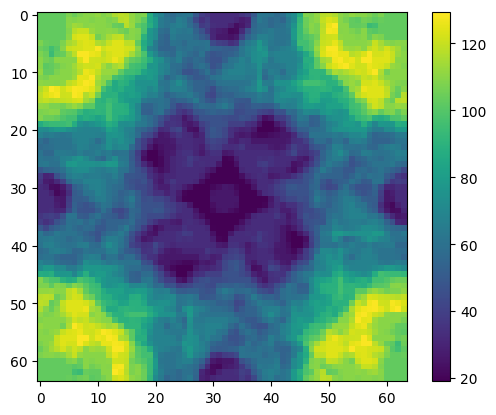

PyObject <matplotlib.colorbar.Colorbar object at 0x7f4866ac5400>

In [72]:
imshow(ave_epsilon_topo[3, :, :])
colorbar()

In [73]:
function Base.(+)(bs1::BandSummary, bs2::BandSummary)
    
    # check bands have same bandreps & indicator group
    bs1.brs == bs2.brs || error("bands must have identical band representations")
    bs1.indicator_group == bs2.indicator_group || error("bands must have identical indicator group")

    # consecutiveness check for band
    if last(bs1.band) + 1 == first(bs2.band)
        band = first(b1):last(bs2)
    elseif last(bs2.band) + 1 == first(bs1.band)
        band = first(b2):last(bs1)
    else
        throw(DomainError((bs1.band, bs2.band), "bands must be consecutive"))
    end
# length
    
# 

SpaceGroup{2} ⋕9 (c2mm) with 8 operations:
 1
 2
 m₁₀
 m₀₁
 {1|½,½}
 {2|½,½}
 {m₁₀|½,½}
 {m₀₁|½,½}

## imshow(ave_epsilon_topo[9, :, :])

In [ ]:
# Categorize based on symmetry vectors
#
# singularities
# Method to add band summaries
# Cummulative summary


In [42]:
all_topological_te = []
all_fragile_te = []
all_charges_te = []
all_topological_tm = []
all_fragile_tm = []
all_charges_tm = []

all_num_bands_te = []
all_num_bands_tm = []

n_groupings = 40
for sg in (2, 9, 10, 11, 12, 13, 14, 15, 16, 17)
    topological_te = zeros(n_groupings)
    fragile_te = zeros(n_groupings)
    charges_te = zeros(n_groupings)
    topological_tm = zeros(n_groupings)
    fragile_tm = zeros(n_groupings)
    charges_tm = zeros(n_groupings)
    num_bands_te = zeros(n_groupings, n_groupings)
    num_bands_tm = zeros(n_groupings, n_groupings)

    sg in (2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17) || continue
    brs = bandreps(sg, 2)
    println("Calculating spacegroup $sg"); flush(stdout)
    for id in 1:100
        for polarization in ("te", "tm")
            try
                symeigsd, lgd = read_symdata("dim2-sg$sg-$id-res64-$polarization", dir="./symeigs/output")
                lgirsd = pick_lgirreps(lgd)
                lg_gamma = lgd["Γ"]
                signs = [det(rotation(g)) for g in lg_gamma]

                if polarization == "tm"
                    symeigsd["Γ"][1] = ones(length(signs))
                end

                bsummary = analyze_symmetry_data(symeigsd, lgirsd, brs)
                num_summaries = length(bsummary)
                f = vcat([isequal(b.topology, TopologyKind(2)) for b in bsummary], zeros(n_groupings - num_summaries))
                t = vcat([isequal(b.topology, TopologyKind(1)) for b in bsummary], zeros(n_groupings - num_summaries))
                num_bands = [length(b.band) for b in bsummary]
                
                if polarization == "te"
                    fragile_te += f
                    topological_te += t
                    #charges_te += c
                    for (i, nband) in enumerate(num_bands)
                        iszero(nband) && continue
                        num_bands_te[i, nband] += 1
                    end
                else
                    fragile_tm += f
                    topological_tm += t
                    #charges_tm += c
                    for (i, nband) in enumerate(num_bands)
                        iszero(nband) && continue
                        num_bands_tm[i, nband] += 1
                    end
                end
            catch e
                println(e)
            end
        end
    end
    push!(all_num_bands_te, num_bands_te)
    push!(all_num_bands_tm, num_bands_tm)
    push!(all_fragile_te, fragile_te)
    push!(all_topological_te, topological_te)
    push!(all_charges_te, charges_te)
    push!(all_fragile_tm, fragile_tm)
    push!(all_topological_tm, topological_tm)
    push!(all_charges_tm, charges_tm)

end

Calculating spacegroup 2
Calculating spacegroup 9
Calculating spacegroup 10
Calculating spacegroup 11
Calculating spacegroup 12
Calculating spacegroup 13
Calculating spacegroup 14
Calculating spacegroup 15
Calculating spacegroup 16
Calculating spacegroup 17
ErrorException("found no isolable band candidates")


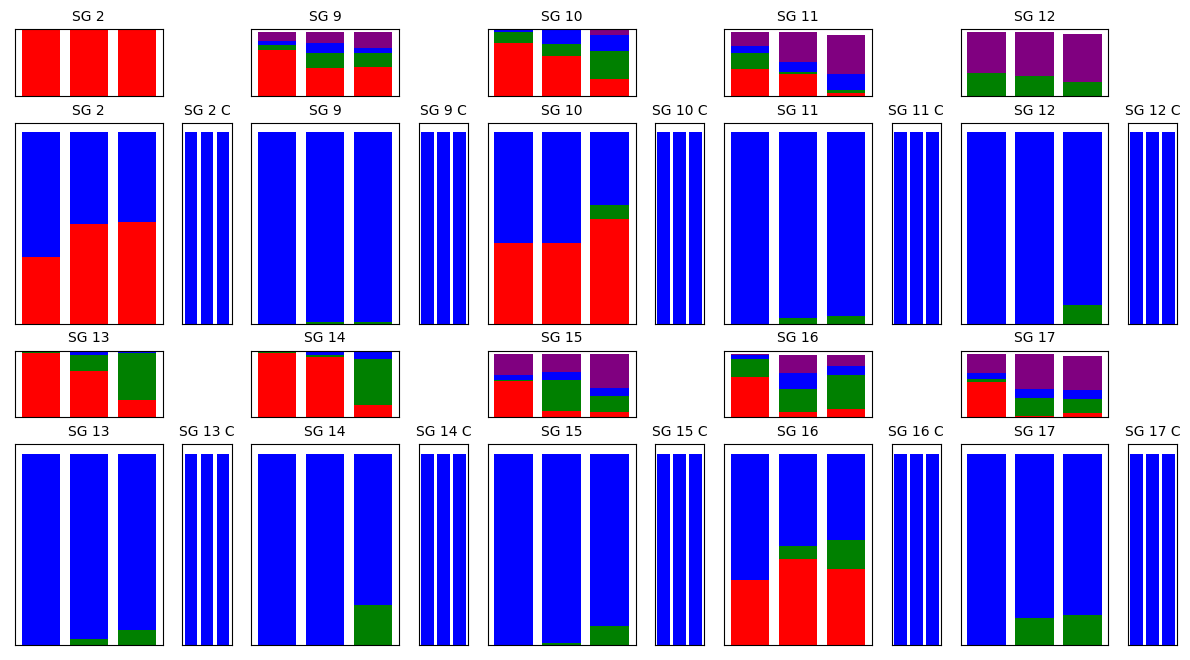

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [43]:
sgs = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]

num_ids = 100
band_set_range = 1:3
fig, (axes) = subplots(4, 10, figsize=(15, 8), gridspec_kw=Dict("width_ratios" => [3, 1, 3, 1, 3, 1, 3, 1, 3, 1], "height_ratios" => [1, 3, 1, 3]))
#xlabel("Band Grouping")
ax_num = 1
for (i, sg) in enumerate(sgs)
    row = i > 5 ? 2 : 1
    col = rem(i, 5)
    col = iszero(col) ? 5 : col
    axes[2row, 2col-1].set_title("SG $sg", size=10)
    axes[2row, 2col-1].bar(band_set_range, all_topological_te[i][band_set_range], color="red", label="topological")
    axes[2row, 2col-1].bar(band_set_range, all_fragile_te[i][band_set_range], bottom = all_topological_te[i][band_set_range], color="green", label = "fragile")
    axes[2row, 2col-1].bar(band_set_range, num_ids .- all_topological_te[i][band_set_range] .- all_fragile_te[i][band_set_range], bottom = all_topological_te[i][band_set_range] + all_fragile_te[i][band_set_range], color="blue", label="trivial")
    axes[2row, 2col].set_title("SG $sg C", size=10)
    axes[2row, 2col].bar(band_set_range, all_charges_te[i][band_set_range], color="red", label="w/ corner charge")
    axes[2row, 2col].bar(band_set_range, num_ids .- all_charges_te[i][band_set_range], bottom = all_charges_te[i][band_set_range], color="blue", label="w/o corner charge")
    
    
    axes[2row, 2col-1].set_yticks([])
    axes[2row, 2col].set_yticks([])
    axes[2row, 2col-1].set_xticks([])
    axes[2row, 2col].set_xticks([])
    axes[2row-1, 2col-1].set_yticks([])
    axes[2row-1, 2col].set_yticks([])
    axes[2row-1, 2col-1].set_xticks([])
    axes[2row-1, 2col].set_xticks([])
    
    axes[2row-1, 2col-1].set_title("SG $sg", size=10)
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 1], color="red", label="topological")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 2], bottom =  all_num_bands_te[i][band_set_range, 1], color="green", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][band_set_range, 3], bottom =  vec(sum(all_num_bands_te[i][band_set_range, 1:2], dims=2)), color="blue", label = "fragile")

    axes[2row-1, 2col-1].bar(band_set_range, vec(sum(all_num_bands_te[i][band_set_range, 4:end], dims=2)), bottom =  vec(sum(all_num_bands_te[i][band_set_range, 1:3], dims=2)), color="purple", label = "fragile")
end
delaxes.(axes[1, 2:2:10])
delaxes.(axes[3, 2:2:10])


In [4]:
symeigsd, lgd = read_symdata("dim2-sg17-240-res64-te", dir="./symeigs/output")
lgirsd = pick_lgirreps(lgd)
brs = bandreps(17, 2)

BandRepSet (⋕17): 13 BandReps, sampling 13 LGIrreps (spin-1 w/ TR)
────┬────────────────────────────────────────────────────
    │ 3c  3c  3c  3c  2b  2b  2b  1a  1a  1a  1a  1a  1a 
    │ A₁  A₂  B₂  B₁  A₁  A₂  E   A₁  A₂  B₂  B₁  E₂  E₁ 
────┼────────────────────────────────────────────────────
 M₁ │ 1   ·   1   1   1   ·   1   1   ·   ·   ·   1   ·  
 M₂ │ ·   1   1   1   ·   1   1   ·   1   ·   ·   1   ·  
 M₃ │ 1   1   1   ·   ·   1   1   ·   ·   1   ·   ·   1  
 M₄ │ 1   1   ·   1   1   ·   1   ·   ·   ·   1   ·   1  
 Γ₁ │ 1   ·   ·   ·   1   ·   ·   1   ·   ·   ·   ·   ·
 Γ₂ │ ·   1   ·   ·   ·   1   ·   ·   1   ·   ·   ·   ·
 Γ₃ │ ·   ·   1   ·   ·   1   ·   ·   ·   1   ·   ·   ·
 Γ₄ │ ·   ·   ·   1   1   ·   ·   ·   ·   ·   1   ·   ·
 Γ₅ │ 1   1   ·   ·   ·   ·   1   ·   ·   ·   ·   1   ·
 Γ₆ │ ·   ·   1   1   ·   ·   1   ·   ·   ·   ·   ·   1
 K₁ │ 1   ·   1   ·   ·   ·   1   1   ·   1   ·   ·   ·  
 K₂ │ ·   1   ·   1   ·   ·   1   ·   1   ·   1   ·   ·  
 K₃ │ 1   1   1  

In [9]:
bsummary = analyze_symmetry_data(symeigsd, lgirsd, brs)

7-element Vector{MPBUtils.BandSummary}:
 1-band (trivial): [M₂, Γ₂, K₂]
 2-band (trivial): [M₂+M₃, Γ₂+Γ₃, K₃]
 6-band (trivial): [2M₂+2M₃+2M₄, 2Γ₂+Γ₅+Γ₆, 2K₂+2K₃]
 4-band (trivial): [M₁+M₂+M₃+M₄, Γ₅+Γ₆, 2K₃]
 6-band (trivial): [2M₁+2M₂+M₃+M₄, Γ₃+Γ₄+Γ₅+Γ₆, K₁+K₂+2K₃]
 3-band (fragile): [M₂+M₃+M₄, Γ₂+Γ₅, K₁+2K₂]
 15-band (trivial): [4M₁+3M₂+4M₃+4M₄, Γ₁+2Γ₃+2Γ₄+2Γ₅+3Γ₆, 3K₁+2K₂+5K₃]

In [20]:
count([isequal(b.topology, TopologyKind(2)) for b in bsummary])

1

In [13]:
fieldnames(MPBUtils.BandSummary)

(:topology, :band, :n, :brs, :indicators, :indicator_group)

In [25]:
vcat([isequal(b.topology, TopologyKind(2)) for b in bsummary], zeros(33))

40-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0